# Разработка A/B-тестирования и анализ результатов


## Цели и задачи проекта

Проект представляет собой проведение A/B-тестирования нового алгоритма рекомендаций для приложения с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Наша цель - рассчитать параметры A/B-теста, необходимые для корректного результата эксперимента и проанализировать его результаты.

## Структура проекта

1. Загрузка данных и знакомство с ними.
2. Подготовка к A/B-тесту.
3. Мониторинг A/B-теста.
4. Проверка результатов A/B-теста.
5. Итоговые выводы.

## Описание данных

Для работы предоставлены 3 таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).



## Работа с историческими данными (EDA)

Загрузим исторические данные, оценим их структуру и количество, проверим на пропуски и дубликаты, преобработаем и проведём анализ перед тестированием.

### Загрузка исторических данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower

In [2]:
# Выгуржаем данные
sessions_history = pd.read_csv('C:/Users/Andrey/My projects/Shorts/sessions_project_history.csv')

### Знакомство с данными

In [3]:
# Выводим первые строки
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выводим информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [5]:
# Приведём столбец `registration_flag` к логическому типу данных
sessions_history['registration_flag']=sessions_history['registration_flag'].astype('bool')

In [6]:
# Приведём столбцы `session_date`, `session_start_ts` и `install_date` к соответсвующему типу данных
for column in ['session_date', 'session_start_ts', 'install_date']:
    sessions_history[column]=sessions_history[column].astype('datetime64')

In [7]:
# Проверим какие регионы и типы устройств представлены в данных
for column in ['region', 'device']:
    print(sessions_history[column].sort_values().unique())

['CIS' 'EU' 'MENA']
['Android' 'Mac' 'PC' 'iPhone']


In [8]:
# Приведём их к категориальному типу данных
for column in ['region', 'device']:
    sessions_history[column]=sessions_history[column].astype('category')

In [9]:
# Выводим количество уникальных пользователей
sessions_history['user_id'].nunique()

134039

In [10]:
# Проверим правильность указанного периода сбора информации
sessions_history['session_date'].min(), sessions_history['session_date'].max()

(Timestamp('2025-08-11 00:00:00'), Timestamp('2025-09-23 00:00:00'))

In [11]:
# Проверим период регистрации пользователей
sessions_history['install_date'].min(), sessions_history['install_date'].max()

(Timestamp('2025-08-11 00:00:00'), Timestamp('2025-09-10 00:00:00'))

In [12]:
# Проверяем данные на дубликаты
sessions_history.duplicated().sum(), sessions_history.duplicated(subset='session_id').sum()

(0, 0)

#### Вывод
Данные содержат 435924 строк уникальных сессий для 134039 пользователей, совершённых с 2025-08-11 по 2025-09-23. Пользователи совершали сессии с устройств Android, Mac, PC, iPhone из СНГ, Европы и Ближнего Востока. Пропуски и дубликаты в таблице отстуствуют. 

### Анализ числа регистраций

Проанализируем как менялось количество зарегистрированных пользователей за указанный период.

In [13]:
# Группируем всех пользователей по датам 
all_users_dt = sessions_history.groupby('session_date').agg({'user_id': 'nunique'}).reset_index()

In [14]:
# Создаём таблицу только с зарегистрированными пользователями
reg_users = sessions_history[sessions_history['registration_flag']==1]
# Группируем зарегистрированных пользователей по датам
reg_users_dt = reg_users.groupby('session_date').agg({'user_id': 'nunique'}).reset_index()

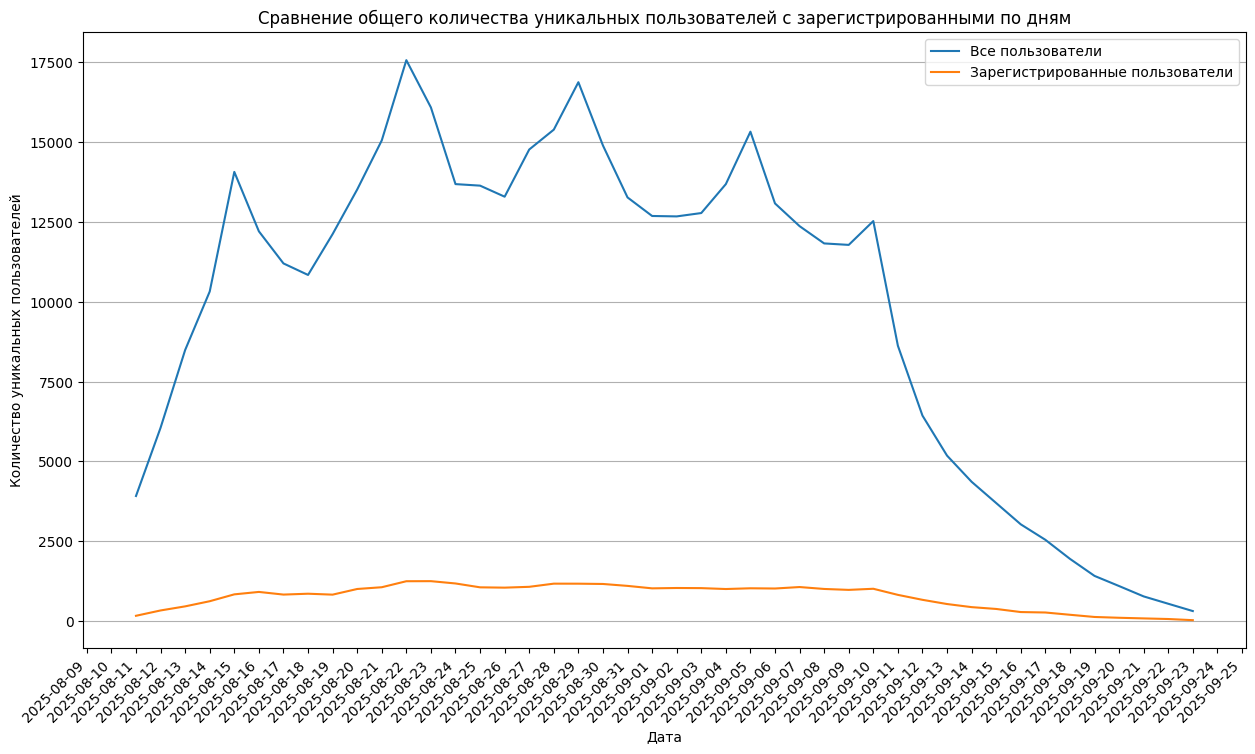

In [15]:
# Строим линейные графики для всех и зарегистрированных пользователей по датам сессий
plt.figure(figsize=(15, 8))
plt.plot(all_users_dt['session_date'].unique(), all_users_dt['user_id'], label ='Все пользователи')
plt.plot(reg_users_dt['session_date'].unique(), reg_users_dt['user_id'], label ='Зарегистрированные пользователи')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Дата')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Количество уникальных пользователей')
plt.title('Сравнение общего количества уникальных пользователей с зарегистрированными по дням')
plt.show()

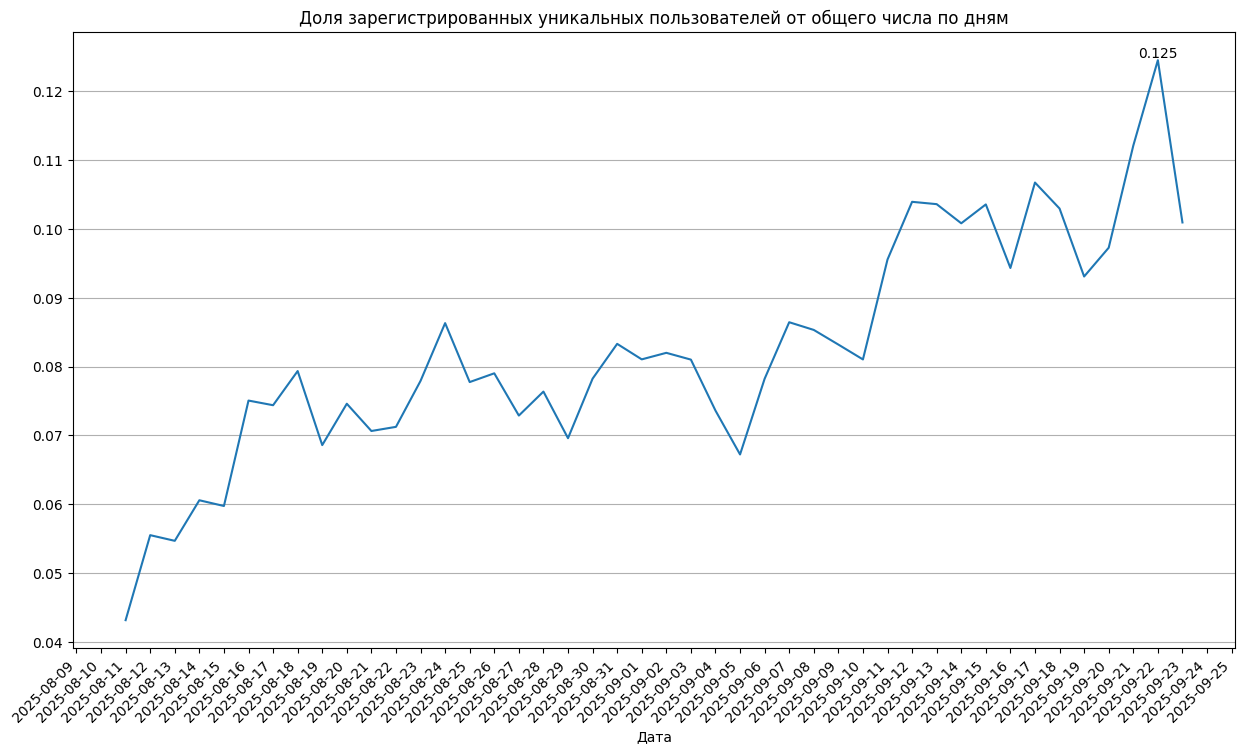

In [16]:
# Строим график для отображения доли зарегистрированных пользователей по дням
ratios = reg_users_dt['user_id']/all_users_dt['user_id']
max_ratio = ratios.max()
max_date = all_users_dt['session_date'][ratios.argmax()]
plt.figure(figsize=(15, 8))
plt.plot(all_users_dt['session_date'].unique(), ratios)
plt.text(max_date, max_ratio, f'{max_ratio:.3f}',
         fontsize=10, ha='center', va='bottom')
plt.grid(axis='y')
plt.xlabel('Дата')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Доля зарегистрированных уникальных пользователей от общего числа по дням')
plt.show()

#### Вывод
На протяжении августа количество уникальных пользователей в день росло с колебананиями. Начиная с 9 сентября начало резко снижаться и опустилось почти до 0 к 23 сентября. При этом доля зарегистрированных уникальных пользователей в день выросла за рассматриваемый период с 3% до 10%.

###  Анализ числа просмотренных страниц
Проанализируем поведение пользователей внутри продукта: оценим сколько страниц за сессию они просматривают.

In [17]:
# Находим количество сессий для каждого значения просмотренных страниц
sessions_history['page_counter'].value_counts()

3    166690
4    105569
2    105536
1     29160
5     26288
6      2589
7        92
Name: page_counter, dtype: int64

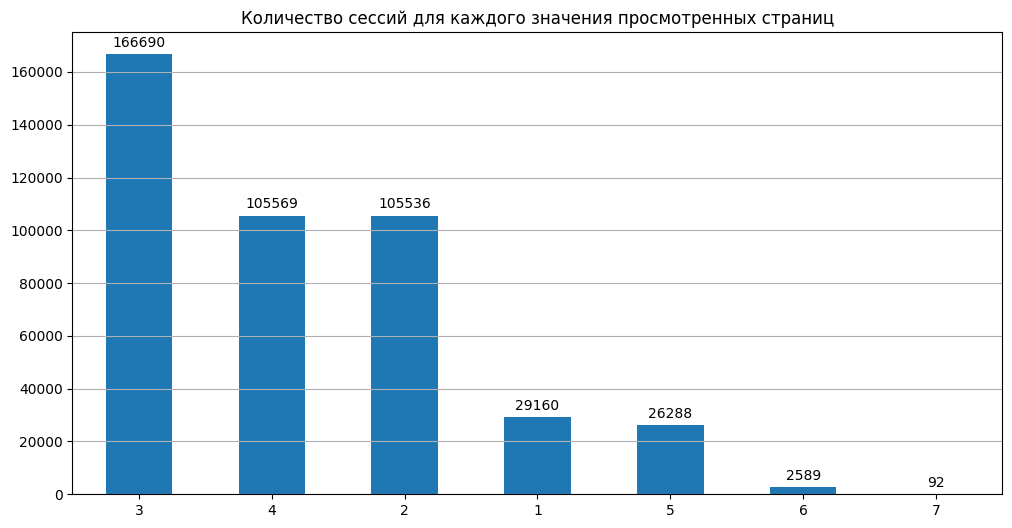

In [18]:
# Строим график для отображения количества сессий для каждого значения просмотренных страниц
data=sessions_history['page_counter'].value_counts()
plt.figure(figsize=(12, 6))
data.plot(
            kind='bar',
            legend=False,
            rot=0,
            title='Количество сессий для каждого значения просмотренных страниц'
)
plt.grid(axis='y')

for x, val in enumerate(data):
    plt.text(x, val + max(data)*0.01, str(val), ha='center', va='bottom')
 
plt.show()

#### Вывод
Наиболее часто пользователи просматривают 2-4 страницы, остальные значения значительно реже.

### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда определила ключевую метрику - это сессии, в которых пользователь просмотрел 4 и более страниц, что говорит об удовлетворённости контентом и алгоритмами рекомендаций. Оценим этот показатель на исторических данных.

In [19]:
# Создадим нужный столбец
sessions_history['good_session'] = np.where(sessions_history['page_counter']>3, True, False)  
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,False,3,CIS,iPhone,False
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,False,4,MENA,Android,True
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,False,4,EU,PC,True
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,False,4,CIS,Android,True
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,False,3,CIS,Android,False


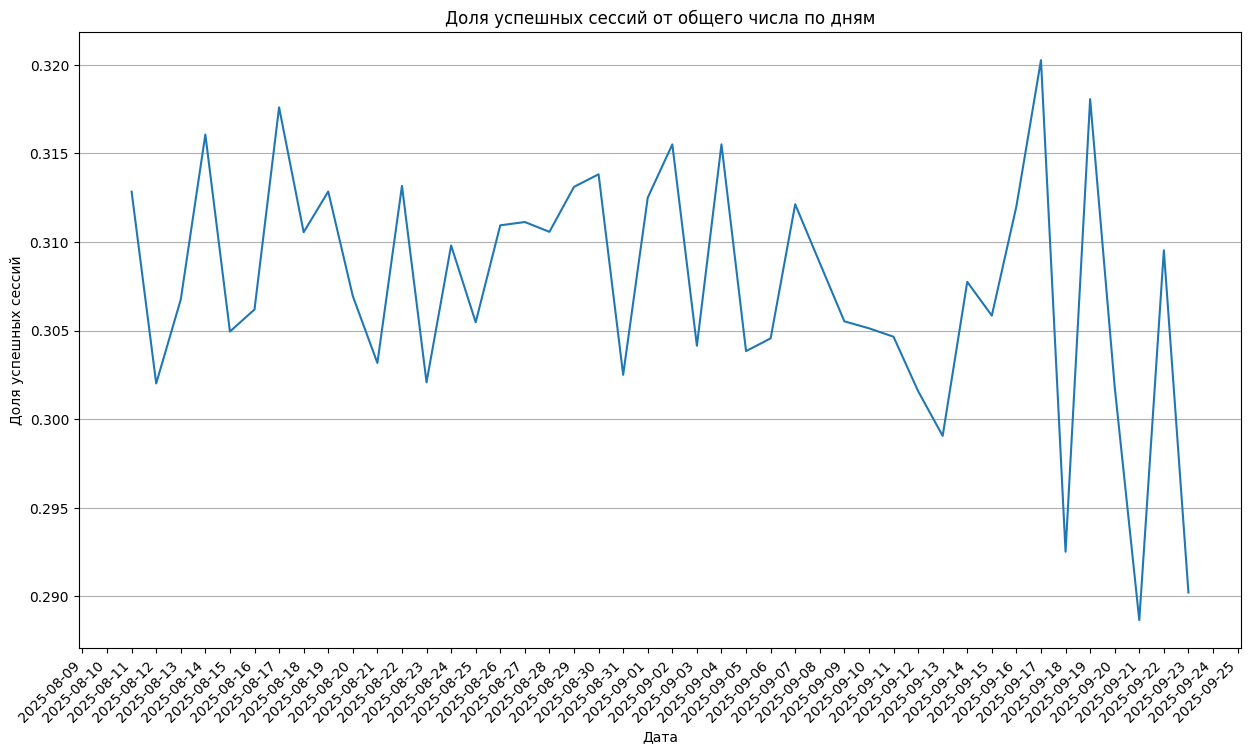

In [20]:
# Группируем долю успешных сессий по дням
good_session_dt = sessions_history.groupby('session_date').agg({'good_session': 'mean'}).reset_index()
# Строим график для отображения доли успешных сессий по дням
plt.figure(figsize=(15, 8))
plt.plot(good_session_dt['session_date'].unique(), good_session_dt['good_session'])
plt.grid(axis='y')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Доля успешных сессий от общего числа по дням')
plt.show()

#### Вывод
На протяжении рассматриваемого периода ключевая метрика была в диапазоне от 29 до 32%. В последние 2 недели периода это значение подверглось наибольшим колебаниям.

##  Подготовка к тесту
Сформулируем гипотезу, которую будем тестировать и определим параметры теста.

### Формулирование гипотезы

Нулевая гипотеза: внедрение нового алгоритма рекомендаций не увеличит долю успешных сессий или это увеличение не будет статистически значимо.

Альтернативная гипотеза: внедрение нового алгоритма рекомендаций увеличит долю успешных сессий и это увеличение будет статистически значимо.

### Расчёт размера выборки
Выбираем уровень значимости равный 5% - это стандартное значение для маркетинговых тестов. Мощность определим как 80%, так как это позволяет сохранить баланс между длительностью теста и его достоверностью. Базовую конверсию возмём среднюю за исторический период - 30%, желаемый mde - 1%.

In [21]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста
beta = 1-power  # Ошибка второго рода
mde = 0.01  # Минимальный детектируемый эффект
p1 = 0.3  # Базовая конверсия 
p2 = p1 + mde # Ожидаемая конверсия

# Рассчитываем размер выборки
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(
    effect_size = (p2 - p1) / np.sqrt((p1*(1-p1) + p2*(1-p2))/2),
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 33271


### Расчёт длительности A/B-теста


In [22]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = all_users_dt['user_id'].mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration*2} дней.")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 8 дней.


## Мониторинг А/В-теста

Получили данные за первый день тестирования. Проверим правильность распредения пользователей по группам. В группе A - пользователи со старым алгоритмом, в В - с новым.

### Проверка распределения пользователей
Оценим как пользователи распределяются по группам.

In [23]:
# Создаём таблицу с данными за первый день тестирования
sessions_test_part = pd.read_csv('C:/Users/Andrey/My projects/Shorts/sessions_project_test_part.csv')

In [24]:
# Делим пользователей по группам и оставляем уникальных
sessions_test_part_A = sessions_test_part[sessions_test_part['test_group']=='A']
sessions_test_part_B = sessions_test_part[sessions_test_part['test_group']=='B']
sessions_test_part_A_unique = sessions_test_part_A.drop_duplicates(subset=['user_id'])
sessions_test_part_B_unique = sessions_test_part_B.drop_duplicates(subset=['user_id'])

In [25]:
# Высчитываем процентную разницу между группами
dif_percent = 100 * abs(len(sessions_test_part_A_unique)-len(sessions_test_part_B_unique))/len(sessions_test_part_A_unique)
dif_percent

0.7447528774542993

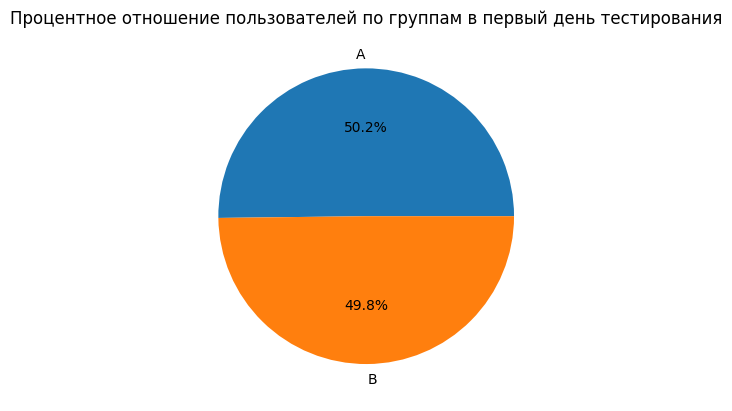

In [26]:
# Строим график для визуализации этой разницы
sessions_test_part_unique = sessions_test_part.drop_duplicates(subset=['user_id'])
sessions_test_part_unique['test_group'].value_counts().plot(kind='pie',ylabel='',autopct='%.1f%%')
plt.title('Процентное отношение пользователей по группам в первый день тестирования')
plt.show()

### Проверка пересечений пользователей
Проверим, что никто из пользователей не попал в обе группы одновременно.

In [27]:
# Ищем пользователей, которые могли попасть в обе группы одновременно
intersection = list(set(sessions_test_part_A_unique['user_id']) & set(sessions_test_part_B_unique['user_id']))
intersection

[]

Пересечений не обнаружено.

### Равномерность разделения пользователей по устройствам
Проверим, есть ли разница между группами по устройствам пользователей.

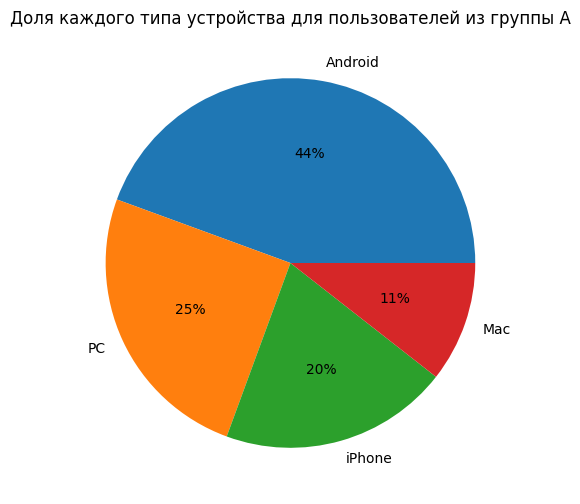

In [28]:
# Строим график распределения устройств пользователей в группе А
plt.figure(figsize=(12, 6))
sessions_test_part_A_unique['device'].value_counts().plot(kind='pie',legend=False,rot=0,ylabel='',autopct='%.0f%%')
plt.title('Доля каждого типа устройства для пользователей из группы A')
plt.show()

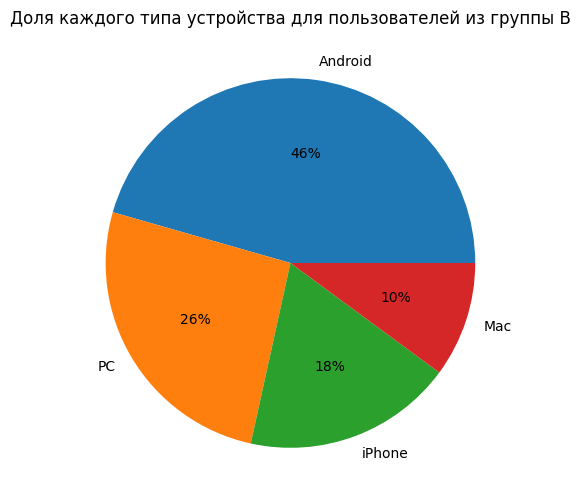

In [29]:
# Строим график распределения устройств пользователей в группе В
plt.figure(figsize=(12, 6))
sessions_test_part_B_unique['device'].value_counts().plot(kind='pie',ylabel='',autopct='%.0f%%')
plt.title('Доля каждого типа устройства для пользователей из группы В')
plt.show()

### Равномерность распределения пользователей по регионам
Проверим, есть ли разница между группами по регионам пользователей.

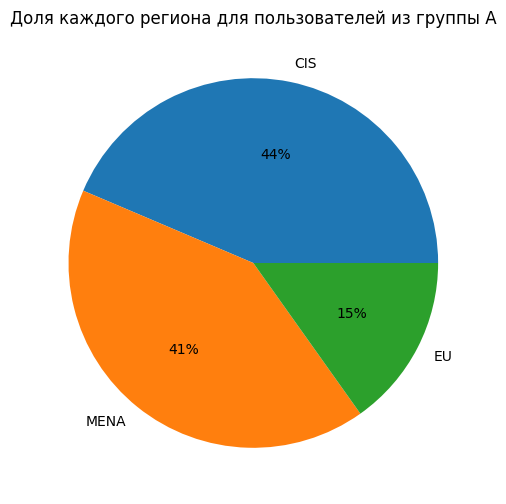

In [30]:
# Строим график распределения пользователей по регионам в группе А
plt.figure(figsize=(12, 6))
sessions_test_part_A_unique['region'].value_counts().plot(kind='pie',ylabel='',autopct='%.0f%%')
plt.title('Доля каждого региона для пользователей из группы A')
plt.show()

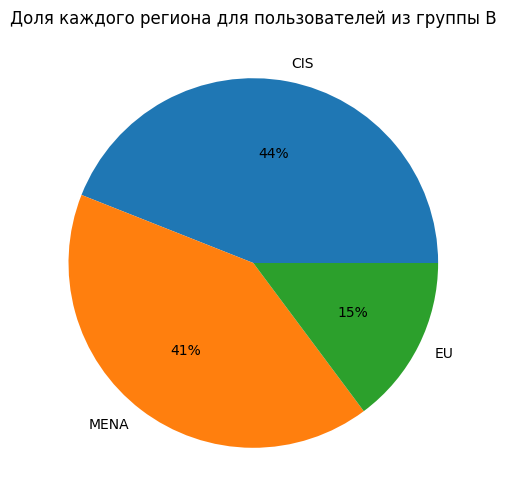

In [31]:
# Строим график распределения пользователей по регионам в группе В
plt.figure(figsize=(12, 6))
sessions_test_part_B_unique['region'].value_counts().plot(kind='pie',legend=False,rot=0,ylabel='',autopct='%.0f%%')
plt.title('Доля каждого региона для пользователей из группы В')
plt.show()

### Вывод после проверки A/B-теста


По результатам первого дня теста:
- Разница между количеством пользователей в группах составялет менее 1%.
- Выборки являются независимыми, пересечения пользователей не обнаружено.
- Сохраняется равномерное распределение пользователей по регионам и устройствам: разница не более 2%.

Можно сделать вывод, что A/B-тест проходит корректно.

## Проверка результатов A/B-теста

A/B-тест завершён, получили полные результаты. Оценим корректность его проведения и сделаем выводы.

### Получение результатов теста и подсчёт основной метрики

In [32]:
# Создаём таблицу с данными за весь период тестирования
sessions_test = pd.read_csv('C:/Users/Andrey/My projects/Shorts/sessions_project_test.csv')

In [33]:
# Создадим новый стоблец для сессий с 4 и более страниц
sessions_test['good_session']= np.where(sessions_test['page_counter']>3, True, False) 
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,False
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,False
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,False
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,False
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,False


### Проверка корректности результатов теста
Оценим количество сессий, совершённых пользователями каждой группы.

In [34]:
# Группируем всех пользователей по датам и группам
sessions_test_dt = sessions_test.groupby(['session_date','test_group']).agg({'user_id': 'nunique'}).reset_index()

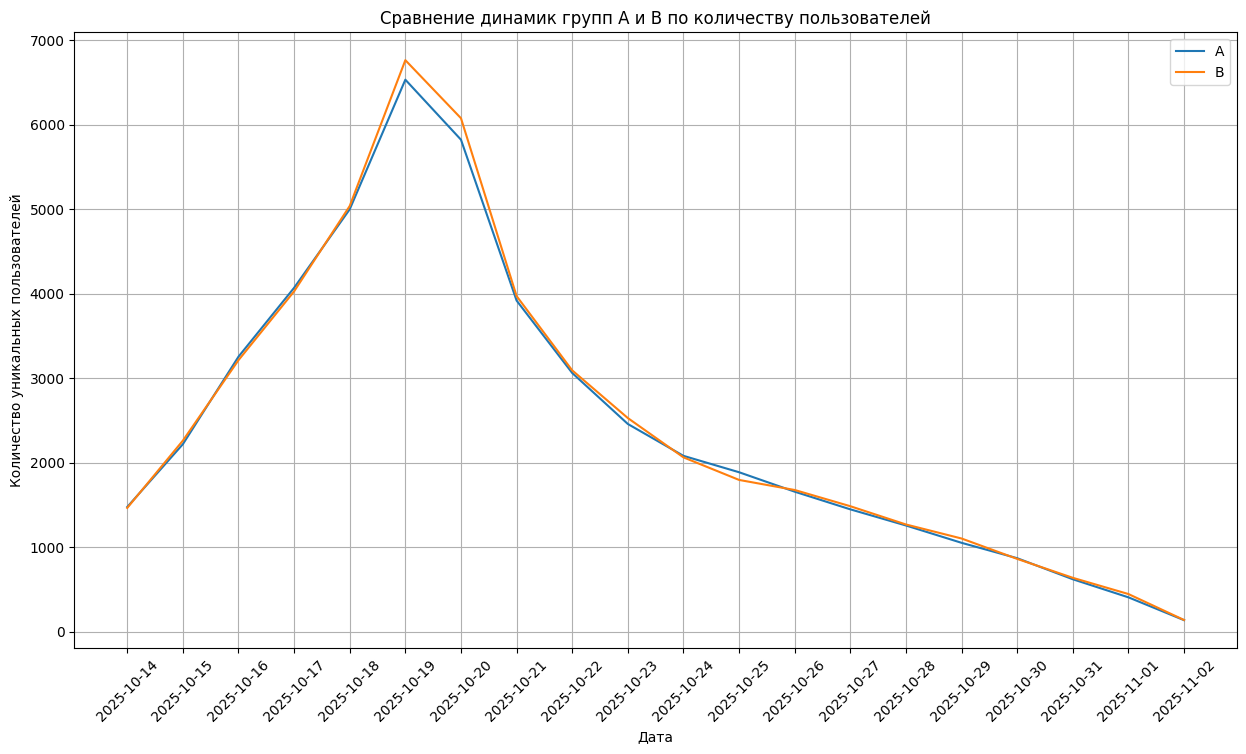

In [35]:
# Построим визуализацию для отображения динамики количества пользователей в обеих группах
plt.figure(figsize=(15, 8))
plt.plot(sessions_test_dt['session_date'].unique(), sessions_test_dt[sessions_test_dt['test_group']=='A']['user_id'], label ='A')
plt.plot(sessions_test_dt['session_date'].unique(), sessions_test_dt[sessions_test_dt['test_group']=='B']['user_id'],label ='B')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество уникальных пользователей")
plt.grid(True)
plt.legend()
plt.title('Сравнение динамик групп A и B по количеству пользователей')
plt.show()

In [36]:
# Проведём t-тест Уэлча для проверки равенства средних двух выборок
alpha = 0.05
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    sessions_test_dt[sessions_test_dt.test_group=='A']['user_id'], 
    sessions_test_dt[sessions_test_dt.test_group=='B']['user_id'], 
    equal_var=False,
    alternative='two-sided' # альтернативная гипотеза - выборочные средние двух выборок не равны
) 
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны')
    print('Интерпретация: количество уникальных дневных сессий в двух выборках различается')

p-value теста Уэлча =0.95
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы


### Сравнение доли успешных сессий
Проанализируем ключевую метрику - долю успешных сессий.

In [37]:
# Определим долю успешных сессий и разницу между ними
good_session_A = sessions_test[sessions_test['test_group']=='A']['good_session'].mean()
good_session_B = sessions_test[sessions_test['test_group']=='B']['good_session'].mean()
dif_good_session = 100 * abs(good_session_A - good_session_B)/good_session_A
print(f"Доля успешных сессий в группе А составляет {round((100*good_session_A),2)}%. В группе В - {round((100*good_session_B),2)}%. Разница между ними в обеих группах составляет {round((dif_good_session),1)}%.")

Доля успешных сессий в группе А составляет 30.77%. В группе В - 31.83%. Разница между ними в обеих группах составляет 3.4%.


### Насколько статистически значимо изменение ключевой метрики
Оценим статистическую значимость разницы между тестируемыми группами.

In [38]:
# Проверим выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок
count_session_A = sessions_test[sessions_test['test_group']=='A'].shape[0]
count_session_B = sessions_test[sessions_test['test_group']=='B'].shape[0]
count_good_session_A = sessions_test[(sessions_test['good_session']== 1)&(sessions_test['test_group']=='A')].shape[0]
count_good_session_B = sessions_test[(sessions_test['good_session']== 1)&(sessions_test['test_group']=='B')].shape[0]

if (good_session_A*count_session_A > 10)and((1-good_session_A)*count_session_A > 10)and(good_session_B*count_session_B > 10)and((1-good_session_B)*count_session_B > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [39]:
# Проведём Z-тест пропорций для определения значимости изменения успешных сессий
alpha = 0.05
stat_ztest, p_value_ztest = proportions_ztest(
    [count_good_session_A, count_good_session_B],
    [count_session_A, count_session_B],
    alternative='smaller' # так как good_session_A < good_session_B
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпретация: доля успешных сессий в двух выборках не различается или различия не статистически значимы')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпретация: доля успешных сессий в группе В выше чем в группе А!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!
Интерпретация: доля успешных сессий в группе В выше чем в группе А!


## Вывод по результатам A/B-эксперимента

Выводы A/B-эксперимента:
- Для тестирования нового алгоритма рекомендаций было задействовано 30579 пользователей в контрольной и тестовой группах. Длительность эксперимента составила 20 дней.
- Внедрение нового алгоритма рекомендаций увеличило долю успешных сессий (с просмотром 4 и более страниц) с 30.77% до 31.83%.
- pvalue для оценки статистической значимости выявленного эффекта составило 0.0001575, что значительно ниже уровня значимости в 0.05.
- Внедрять нововведение в приложение стоит, так как целевая метрика выросла, при этом пользователи по группам были распределены корректно, различий между группами в ходе эксперимента замечено не было.